In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader
from torchvision import transforms
import pandas as pd
import numpy as np

In [0]:
import os

# Data loading

In [3]:
from google.colab import drive # I've used google colab for this
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = '/content/gdrive/My Drive/bg_task/'

In [0]:
opj = os.path.join

In [0]:
import zipfile
path_to_zip_file = opj(PATH, 'camera_relocalization_sample_dataset.zip')
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')

In [0]:
# zip_ref.extractall(os.path.join(PATH, 'data'))
zip_ref.close()

In [0]:
DATA_PATH = opj(PATH, 'data/camera_relocalization_sample_dataset/')

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)

In [0]:
from IPython.display import Image

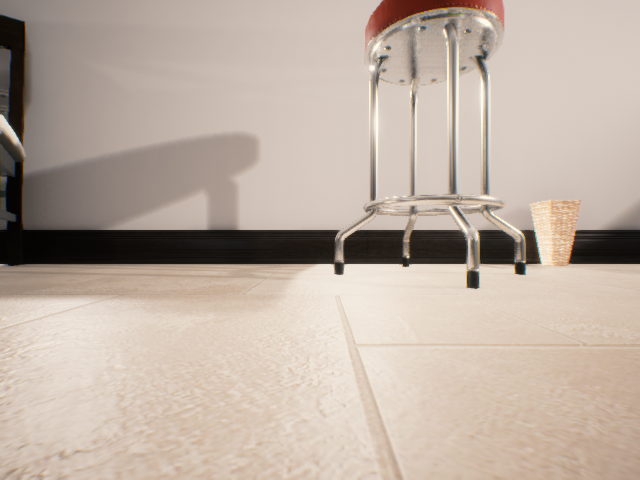

In [11]:
Image(filename=opj(DATA_PATH, 'images/img_0_0_1542098919031247900.png'))

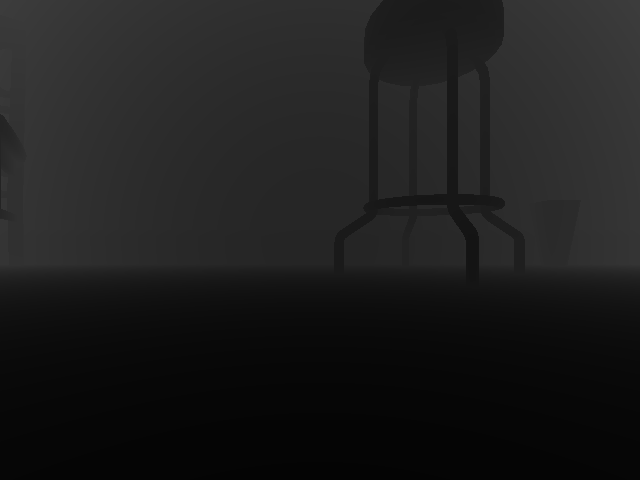

In [12]:
from IPython.display import Image
Image(filename=opj(DATA_PATH, 'images/img_0_3_1542098919034924900.png'))

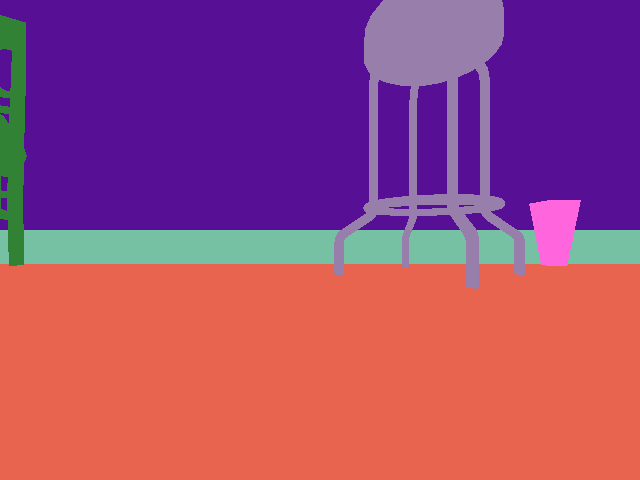

In [13]:
from IPython.display import Image
Image(filename=opj(DATA_PATH, 'images/img_0_5_1542098919037481300.png'))

In [14]:
np.array(default_loader(opj(DATA_PATH, 'images/img_0_0_1542098919031247900.png'))).astype(float)

array([[[128., 120., 116.],
        [129., 120., 116.],
        [129., 120., 116.],
        ...,
        [211., 198., 190.],
        [210., 198., 190.],
        [210., 198., 189.]],

       [[129., 120., 116.],
        [129., 120., 116.],
        [130., 120., 116.],
        ...,
        [210., 198., 190.],
        [210., 198., 189.],
        [211., 198., 190.]],

       [[129., 120., 116.],
        [129., 120., 116.],
        [129., 121., 116.],
        ...,
        [210., 198., 189.],
        [211., 198., 190.],
        [211., 198., 190.]],

       ...,

       [[184., 162., 142.],
        [184., 163., 146.],
        [181., 161., 146.],
        ...,
        [179., 156., 138.],
        [179., 155., 137.],
        [178., 154., 136.]],

       [[181., 161., 146.],
        [181., 161., 145.],
        [177., 157., 141.],
        ...,
        [180., 157., 140.],
        [179., 156., 138.],
        [178., 155., 138.]],

       [[179., 159., 144.],
        [176., 156., 141.],
        [173., 1

# Dataset

In [0]:
class CRDataset(Dataset):
    def __init__(self, path_to_csv: str, images_path: str, transform, precomputed_mean=None, indices=None, cache=True): # use cache with DataLoader num_workers=0
        self.df = pd.read_csv(path_to_csv)
        if indices is not None:
            self.df = self.df.iloc[indices]
        self.images_path = images_path
        self.transform = transform
        self.cache = {} if cache else None
        
        if precomputed_mean is not None:
            self.image_mean = precomputed_mean
            return 
        
        self.image_mean = np.zeros((*train_transform.transforms[1].size, 3)).astype(float) # assume that second transform is crop
        counter = 0
        for img_file in self.df['ImageFile']: # for mean subtraction as described in PoseNet paper
            counter += 1
            img = default_loader(os.path.join(self.images_path, img_file))
            img = self.transform(img)
            self.image_mean += np.array(img).astype(float)
        self.image_mean /= counter           

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, item):
        row = self.df.iloc[item]
        
        target = np.array(row['POS_X':'Q_Z']).astype(float)

        img_file = row['ImageFile']
        if self.cache is not None and img_file in self.cache:
            return self.cache[img_file]
        
        image_path = os.path.join(self.images_path, img_file)
        image = default_loader(image_path)
        img = self.transform(image)
        x = torch.Tensor((np.array(img).astype(float) - self.image_mean).transpose(2, 0, 1))
        target = torch.Tensor(target)
        if self.cache is not None:
            self.cache[img_file] = (x, target)
        return x, target

In [0]:
train_transform = transforms.Compose([
            transforms.Resize((256, 341)),
            transforms.RandomCrop((224, 224)),
#             lambda x: torch.from_numpy(np.array(x).astype(np.float32).transpose(2, 0, 1)), # cuz transforms.ToTensor rescales img to [0, 1]
#             transforms.ToTensor(),
#             normalize
            ])

In [0]:
pm = None

In [0]:
dataset = CRDataset(opj(DATA_PATH, 'info.csv'), opj(DATA_PATH, 'images'), train_transform, None)

In [0]:
pm = dataset.image_mean

In [19]:
sample = dataset[0]
sample[0].shape

torch.Size([3, 224, 224])

In [109]:
len(dataset.cache)

1

In [0]:
from matplotlib import pyplot as plt

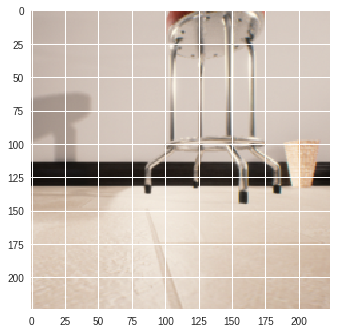

In [121]:
plt.imshow((np.array(sample[0]).transpose(1, 2, 0) + dataset.image_mean).astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


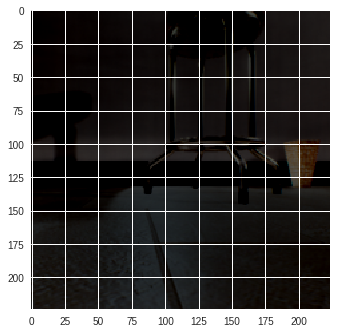

In [122]:
plt.imshow(np.array(sample[0]).transpose(1, 2, 0).astype(int))

In [0]:
import pickle

# Model

In [0]:
from collections import OrderedDict


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# based on GoogLeNet implementation from https://github.com/vadimkantorov/metriclearningbench/blob/master/inception_v1_googlenet.py
# added regression heads & stuff
# output of this network in train mode is a list of outputs from each head;
# in eval mode returns output only from last head
class PosenetGooglenet(nn.Module):
    def __init__(self, dropout_rates=(0.7, 0.7, 0.4)):
        super(PosenetGooglenet, self).__init__()
          
        self.layers = nn.Sequential(OrderedDict([ # layers of GoogLeNet without heads
            ('conv1', nn.Sequential(OrderedDict([
                ('7x7_s2', nn.Conv2d(3, 64, (7, 7), (2, 2), (3, 3))),
                ('relu1', nn.ReLU(True)),
                ('pool1', nn.MaxPool2d((3, 3), (2, 2), ceil_mode=True)),
                ('lrn1', nn.CrossMapLRN2d(5, 0.0001, 0.75, 1))
            ]))),

            ('conv2', nn.Sequential(OrderedDict([
                ('3x3_reduce', nn.Conv2d(64, 64, (1, 1), (1, 1), (0, 0))),
                ('relu1', nn.ReLU(True)),
                ('3x3', nn.Conv2d(64, 192, (3, 3), (1, 1), (1, 1))),
                ('relu2', nn.ReLU(True)),
                ('lrn2', nn.CrossMapLRN2d(5, 0.0001, 0.75, 1)),
                ('pool2', nn.MaxPool2d((3, 3), (2, 2), ceil_mode=True))
            ]))),

            ('inception_3a', InceptionModule(192, 64, 96, 128, 16, 32, 32)),
            ('inception_3b', InceptionModule(256, 128, 128, 192, 32, 96, 64)),

            ('pool3', nn.MaxPool2d((3, 3), (2, 2), ceil_mode=True)),

            ('inception_4a', InceptionModule(480, 192, 96, 208, 16, 48, 64)),
            ('inception_4b', InceptionModule(512, 160, 112, 224, 24, 64, 64)),
            ('inception_4c', InceptionModule(512, 128, 128, 256, 24, 64, 64)),
            ('inception_4d', InceptionModule(512, 112, 144, 288, 32, 64, 64)),
            ('inception_4e', InceptionModule(528, 256, 160, 320, 32, 128, 128)),

            ('pool4', nn.MaxPool2d((3, 3), (2, 2), ceil_mode=True)),

            ('inception_5a', InceptionModule(832, 256, 160, 320, 32, 128, 128)),
            ('inception_5b', InceptionModule(832, 384, 192, 384, 48, 128, 128)),
        ]))
        
        self.head1 = nn.Sequential(OrderedDict([
                      ('pool', nn.AvgPool2d(kernel_size=5, stride=3)),
                      ('conv', nn.Conv2d(512, 128, kernel_size=1)),
                      ('relu1', nn.ReLU(inplace=True)),
                      ('flatten', Flatten()),
                      ('fc', nn.Linear(2048, 1024)),
                      ('relu2', nn.ReLU(inplace=True)),
                      ('dropout', nn.Dropout(p=dropout_rates[0])),#, inplace=True)), # dropout rates from original GoogLeNet paper
                      ('regressor', nn.Linear(1024, 7))
                      ]))
        
        self.head2 = nn.Sequential(OrderedDict([
                      ('pool', nn.AvgPool2d(kernel_size=5, stride=3)),
                      ('conv', nn.Conv2d(528, 128, kernel_size=1)),
                      ('relu1', nn.ReLU(inplace=True)),
                      ('flatten', Flatten()),
                      ('fc', nn.Linear(2048, 1024)),
                      ('relu2', nn.ReLU(inplace=True)),
                      ('dropout', nn.Dropout(p=dropout_rates[1])), #, inplace=True)),
                      ('regressor', nn.Linear(1024, 7))
                      ]))
        
        self.head3 = nn.Sequential(OrderedDict([
                      ('pool', nn.AvgPool2d(kernel_size=7, stride=1)),
                      ('flatten', Flatten()),
                      ('fc', nn.Linear(1024, 2048)), # feature layer described in PoseNet paper
                      ('relu', nn.ReLU(inplace=True)),
                      ('dropout', nn.Dropout(p=dropout_rates[2])), #, inplace=True)),
                      ('regressor', nn.Linear(2048, 7))
                      ]))
        
    def forward(self, input):
        outputs = []
        current_output = input
        if self.training:
            for i in self.layers.named_children():
                name, module = i[0], i[1]
                current_output = module(current_output)
                if name == 'inception_4a':
                    outputs.append(self.head1(current_output))
                if name == 'inception_4d':
                    outputs.append(self.head2(current_output))
        else:
            current_output = self.layers(input)    
        outputs.append(self.head3(current_output))
        return outputs
            

class InceptionModule(nn.Module):
	def __init__(self, inplane, outplane_a1x1, outplane_b3x3_reduce, outplane_b3x3, outplane_c5x5_reduce, outplane_c5x5, outplane_pool_proj):
		super(InceptionModule, self).__init__()
		a = nn.Sequential(OrderedDict([
			('1x1', nn.Conv2d(inplane, outplane_a1x1, (1, 1), (1, 1), (0, 0))),
			('1x1_relu', nn.ReLU(True))
		]))

		b = nn.Sequential(OrderedDict([
			('3x3_reduce', nn.Conv2d(inplane, outplane_b3x3_reduce, (1, 1), (1, 1), (0, 0))),
			('3x3_relu1', nn.ReLU(True)),
			('3x3', nn.Conv2d(outplane_b3x3_reduce, outplane_b3x3, (3, 3), (1, 1), (1, 1))),
			('3x3_relu2', nn.ReLU(True))
		]))

		c = nn.Sequential(OrderedDict([
			('5x5_reduce', nn.Conv2d(inplane, outplane_c5x5_reduce, (1, 1), (1, 1), (0, 0))),
			('5x5_relu1', nn.ReLU(True)),
			('5x5', nn.Conv2d(outplane_c5x5_reduce, outplane_c5x5, (5, 5), (1, 1), (2, 2))),
			('5x5_relu2', nn.ReLU(True))
		]))

		d = nn.Sequential(OrderedDict([
			('pool_pool', nn.MaxPool2d((3, 3), (1, 1), (1, 1))),
			('pool_proj', nn.Conv2d(inplane, outplane_pool_proj, (1, 1), (1, 1), (0, 0))),
			('pool_relu', nn.ReLU(True))
		]))
		
		for container in [a, b, c, d]:
			for name, module in container.named_children():
				self.add_module(name, module)

		self.branches = [a, b, c, d]

	def forward(self, input):
		return torch.cat([branch(input) for branch in self.branches], 1)

# GoogLeNet pretrained weights

In [0]:
weights = pickle.load(open(opj(PATH, 'places-googlenet.pickle'), "rb"), encoding="bytes")

In [125]:
print(list(weights.keys()))

[b'conv1/7x7_s2_0', b'conv1/7x7_s2_1', b'conv2/3x3_reduce_0', b'conv2/3x3_reduce_1', b'conv2/3x3_0', b'conv2/3x3_1', b'inception_3a/1x1_0', b'inception_3a/1x1_1', b'inception_3a/3x3_reduce_0', b'inception_3a/3x3_reduce_1', b'inception_3a/3x3_0', b'inception_3a/3x3_1', b'inception_3a/5x5_reduce_0', b'inception_3a/5x5_reduce_1', b'inception_3a/5x5_0', b'inception_3a/5x5_1', b'inception_3a/pool_proj_0', b'inception_3a/pool_proj_1', b'inception_3b/1x1_0', b'inception_3b/1x1_1', b'inception_3b/3x3_reduce_0', b'inception_3b/3x3_reduce_1', b'inception_3b/3x3_0', b'inception_3b/3x3_1', b'inception_3b/5x5_reduce_0', b'inception_3b/5x5_reduce_1', b'inception_3b/5x5_0', b'inception_3b/5x5_1', b'inception_3b/pool_proj_0', b'inception_3b/pool_proj_1', b'inception_4a/1x1_0', b'inception_4a/1x1_1', b'inception_4a/3x3_reduce_0', b'inception_4a/3x3_reduce_1', b'inception_4a/3x3_0', b'inception_4a/3x3_1', b'inception_4a/5x5_reduce_0', b'inception_4a/5x5_reduce_1', b'inception_4a/5x5_0', b'inception_4a/5

In [126]:
print(list(filter(lambda x: b'loss' in x, weights.keys())))

[b'loss1/conv_0', b'loss1/conv_1', b'loss1/fc_0', b'loss1/fc_1', b'loss1/classifier_0', b'loss1/classifier_1', b'loss2/conv_0', b'loss2/conv_1', b'loss2/fc_0', b'loss2/fc_1', b'loss2/classifier_0', b'loss2/classifier_1', b'loss3/classifier_0', b'loss3/classifier_1']


In [127]:
weights[b'conv1/7x7_s2_0'].shape

(64, 3, 7, 7)

In [0]:
def switch_gradient(module: nn.Module, state: bool):
    for param in module.parameters():
        param.requires_grad = state

In [0]:
net = PosenetGooglenet()

In [463]:
net.training

True

In [0]:
_ = net.train()
# _ = net.eval()

In [465]:
net.head1.conv.weight[0][:3]

tensor([[[ 0.0395]],

        [[-0.0246]],

        [[ 0.0035]]], grad_fn=<SliceBackward>)

In [0]:
# we can transfer weights to non-head layers and conv layers of heads
weights_statedict = {}
for key in weights.keys():
    new_key = key.decode()
    if not 'loss' in new_key:
        new_key = 'layers.' +  new_key
    elif 'conv' in new_key:
        new_key = new_key.replace('loss', 'head')
    else:
        continue
    new_key = new_key.replace('/', '.')
    new_key = new_key.replace('_0', '.weight')
    new_key = new_key.replace('_1', '.bias')
    weights_statedict[new_key] = torch.Tensor(weights[key])

In [0]:
net.load_state_dict(weights_statedict, strict=False)

In [468]:
net.head1.conv.weight[0][:3]

tensor([[[ 0.0266]],

        [[-0.0200]],

        [[ 0.0261]]], grad_fn=<SliceBackward>)

In [145]:
list(net.state_dict().keys())[-10:]

['head2.conv.weight',
 'head2.conv.bias',
 'head2.fc.weight',
 'head2.fc.bias',
 'head2.regressor.weight',
 'head2.regressor.bias',
 'head3.fc.weight',
 'head3.fc.bias',
 'head3.regressor.weight',
 'head3.regressor.bias']

In [146]:
list(weights.keys())[-45:-35]

[b'inception_4d/pool_proj_1',
 b'loss2/conv_0',
 b'loss2/conv_1',
 b'loss2/fc_0',
 b'loss2/fc_1',
 b'loss2/classifier_0',
 b'loss2/classifier_1',
 b'inception_4e/1x1_0',
 b'inception_4e/1x1_1',
 b'inception_4e/3x3_reduce_0']

In [147]:
len(weights_statedict.keys())

118

In [148]:
set(net.state_dict().keys()).difference(set(weights_statedict.keys()))

{'head1.fc.bias',
 'head1.fc.weight',
 'head1.regressor.bias',
 'head1.regressor.weight',
 'head2.fc.bias',
 'head2.fc.weight',
 'head2.regressor.bias',
 'head2.regressor.weight',
 'head3.fc.bias',
 'head3.fc.weight',
 'head3.regressor.bias',
 'head3.regressor.weight'}

In [149]:
len(net.state_dict().keys())

130

In [150]:
list(net.state_dict().keys())[-10:]

['head2.conv.weight',
 'head2.conv.bias',
 'head2.fc.weight',
 'head2.fc.bias',
 'head2.regressor.weight',
 'head2.regressor.bias',
 'head3.fc.weight',
 'head3.fc.bias',
 'head3.regressor.weight',
 'head3.regressor.bias']

In [238]:
net.state_dict()['head3.regressor.weight'].shape

torch.Size([7, 2048])

# Initial checks

In [239]:
net.layers(dataset[0][0].view(1, 3, 224, 224)).shape

torch.Size([1, 1024, 7, 7])

In [240]:
net.head3.pool(net.layers(dataset[0][0].view(1, 3, 224, 224))).shape

torch.Size([1, 1024, 1, 1])

In [0]:
sample = dataset[0]
img = sample[0]
target = sample[1]

In [242]:
target

tensor([ 1.6287, -1.3429, -0.0388,  1.0000, -0.0000,  0.0000,  0.0000])

In [243]:
net(img.view(1, 3, 224, 224))

[tensor([[-0.3026,  0.3355,  0.2418, -0.1478,  0.2244,  0.8248,  0.2151]],
        grad_fn=<AddmmBackward>),
 tensor([[ 0.6799, -0.0207, -0.2522, -0.1335, -0.5764,  0.1328,  0.6594]],
        grad_fn=<AddmmBackward>),
 tensor([[ 0.0194,  0.0388, -0.1036,  0.0931, -0.3035, -0.0829, -0.0155]],
        grad_fn=<AddmmBackward>)]

In [244]:
len(list(net.parameters()))

130

In [0]:
sample = dataset[0]
input = sample[0].view(1, 3, 224, 224)
target = sample[1].view(1, 7)

In [0]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
mse = torch.nn.MSELoss()

In [0]:
mse = mse.to('cuda')
input = input.to('cuda')
target = target.to('cuda')
net = net.to('cuda')

In [256]:
for i in range(1000): # sanity check: let's overfit to random crops of 1 img
    loss = 0
    pred = net(input)
    head_weights = (0.3, 0.3, 1)
    b = 8
    # print(pred[])
    optimizer.zero_grad()
    for head_number in range(3):
        vec = pred[head_number]
        position = vec[:, :3]
        orientation = vec[:, -4:]
        position_target = target[:, :3]
        orientation_target = target[:, -4:]
#         print(vec)
#         print(position)
#         print(orientation)
#         print(orientation_target)
        orientation = F.normalize(orientation, p=2, dim=1)
        orientation_target = F.normalize(orientation_target, p=2, dim=1)
#         print(orientation)
#         print(orientation_target)
        position_loss = mse(position, position_target)
        orientation_loss = mse(orientation, orientation_target)
#         print(position_loss, b * orientation_loss)
        loss += head_weights[head_number] * (position_loss + b * orientation_loss)
    if i % 20 == 0:
        print(loss)
    loss.backward()
    optimizer.step()

tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0586, device='cuda:0', grad_fn=<AddBack

In [259]:
vec = net(input)[2]
position = vec[0][:3]
orientation = vec[0][-4:]
orientation = F.normalize(orientation, p=2, dim=0)
print(position, orientation) # looks nice

tensor([ 1.7528, -1.3693, -0.0378], device='cuda:0', grad_fn=<SliceBackward>) tensor([ 0.9981,  0.0365,  0.0084, -0.0483], device='cuda:0',
       grad_fn=<DivBackward0>)


In [258]:
target

tensor([[ 1.6287, -1.3429, -0.0388,  1.0000, -0.0000,  0.0000,  0.0000]],
       device='cuda:0')

# Train val split

In [0]:
indices = torch.randperm(n=1000)

In [0]:
indices = indices.tolist()

In [15]:
indices[:10]

[364, 236, 940, 663, 234, 440, 72, 150, 899, 48]

In [0]:
train_data = CRDataset(opj(DATA_PATH, 'info.csv'), opj(DATA_PATH, 'images'), train_transform, precomputed_mean=None, indices=indices[:800])
mean_img = train_data.image_mean

In [0]:
test_transform = transforms.Compose(train_transform.transforms[:-1] + [transforms.CenterCrop((224, 224))])

In [0]:
test_data = CRDataset(opj(DATA_PATH, 'info.csv'), opj(DATA_PATH, 'images'), test_transform, precomputed_mean=mean_img, indices=indices[800:])

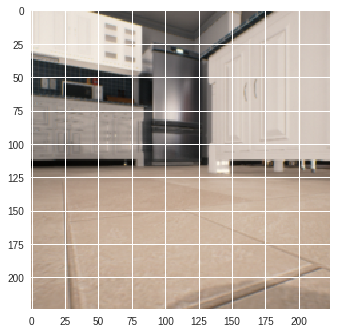

In [114]:
from matplotlib import pyplot as plt
plt.imshow((np.array(test_data[30][0]).transpose(1, 2, 0) + mean_img).astype(int))

# PoseNet loss

In [0]:
def posenet_loss(pred: torch.Tensor, target: torch.Tensor, device='cuda'):
    loss = 0
    head_weights = (0.3, 0.3, 1) if len(pred) == 3 else (1, ) # head weights from GoogLeNet paper
    b = 8
    mse = torch.nn.MSELoss().to(device)
    for head_number in range(len(pred)):
        vec = pred[head_number]
        position = vec[:, :3]
        orientation = vec[:, -4:]
        position_target = target[:, :3]
        orientation_target = target[:, -4:]
        orientation = F.normalize(orientation, p=2, dim=1)
        orientation_target = F.normalize(orientation_target, p=2, dim=1)
        position_loss = mse(position, position_target)
        orientation_loss = mse(orientation, orientation_target)
    #     print(position_loss, b * orientation_loss)
        loss += head_weights[head_number] * (position_loss + b * orientation_loss)
    return loss

# Training

In [0]:
model = PosenetGooglenet()

In [0]:
weights_statedict = {}
for key in weights.keys():
    new_key = key.decode()
    if not 'loss' in new_key:
        new_key = 'layers.' +  new_key
    elif 'conv' in new_key:
        new_key = new_key.replace('loss', 'head')
    else:
        continue
    new_key = new_key.replace('/', '.')
    new_key = new_key.replace('_0', '.weight')
    new_key = new_key.replace('_1', '.bias')
    weights_statedict[new_key] = torch.Tensor(weights[key])

In [0]:
model.load_state_dict(weights_statedict, strict=False)

In [0]:
train_loader = DataLoader(train_data, batch_size=128, num_workers=0, shuffle=True)
val_loader = DataLoader(test_data, batch_size=128, num_workers=0, shuffle=False)

In [0]:
device = 'cuda'
model = model.to(device)

In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
del x, y, pred
del loss
import gc
gc.collect()
torch.cuda.empty_cache()

In [165]:
!nvidia-smi

Tue Mar  5 21:07:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    82W / 149W |   1239MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
switch_gradient(model.layers, False) # train only heads

In [178]:
next(model.layers.parameters()).requires_grad

False

In [0]:
switch_gradient(model.layers, True)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

In [182]:
epochs = 100
for epoch in range(epochs):
    model.train()
#     train_loss = 0
#     count = 0
    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = posenet_loss(pred, y)
#         count += len(x)
#         train_loss += loss.item() * len(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    optimizer.zero_grad()
#     train_loss /= count 
#     print(epoch, train_loss)

    model.eval()
    train_loss = 0
    val_loss = 0
    count = 0
    with torch.no_grad():
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = posenet_loss(pred, y)
            count += len(x)
            train_loss += loss.item() * len(x)
        train_loss /= count
        count = 0
        for x, y in val_loader: # TODO: multiple crop averaging?
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = posenet_loss(pred, y)
            count += len(x)
            val_loss += loss.item() * len(x)
        val_loss /= count 
    print(epoch, train_loss)
    print(epoch, val_loss)

0 0.32327531099319456
0 0.4916633987426758


1 0.30950212478637695
1 0.4296885633468628


2 0.29388041973114015
2 0.4535136461257935


3 0.2841918992996216
3 0.4241343104839325


4 0.2710557860136032
4 0.43922144412994385


5 0.25863604664802553
5 0.4128152394294739


6 0.24703332543373108
6 0.4343640375137329


7 0.23593990206718446
7 0.42984160900115964


8 0.22608792901039124
8 0.41033766746520994


9 0.2171148145198822
9 0.4095727252960205


10 0.2095474624633789
10 0.37427283883094786


11 0.20375476360321046
11 0.4869720077514648


12 0.19642882108688353
12 0.40261300802230837


13 0.1864929485321045
13 0.37730863332748416


14 0.1796409022808075
14 0.3723504638671875


15 0.17039625525474547
15 0.36872342705726624


16 0.16489121675491333
16 0.39795527458190916


17 0.15837240248918533
17 0.37757861137390136


18 0.1525600481033325
18 0.3601656246185303


19 0.1464463096857071
19 0.3520938873291016


20 0.14061201751232147
20 0.34336129903793333


21 0.13509679555892945
21 0.35080237746238707


22 0.13067953050136566
22 0.3270994174480438


23 0.1250191220641136
23 0.34872070789337156


24 0.12105773448944092
24 0.3200285196304321


25 0.11745902299880981
25 0.32994794607162475


26 0.1135070925951004
26 0.34655616521835325


27 0.10906567335128785
27 0.3390807318687439


28 0.10604589849710465
28 0.34628123641014097


29 0.10120761930942536
29 0.3525572717189789


30 0.09785525262355804
30 0.36432899355888365


31 0.09454656302928925
31 0.3344730305671692


32 0.09396651804447174
32 0.3409529495239258


33 0.09082594364881516
33 0.32504207134246826


34 0.08595124006271362
34 0.3189990293979645


35 0.08476046860218048
35 0.3278845000267029


36 0.08316706955432891
36 0.3269398331642151


37 0.08072377204895019
37 0.32071805477142334


38 0.07855040103197097
38 0.3151615846157074


39 0.07509131610393524
39 0.3190746188163757


40 0.07535457611083984
40 0.2947455930709839


41 0.07212001293897628
41 0.27452338457107545


42 0.07031528025865555
42 0.27317656636238097


43 0.0685611253976822
43 0.31624375224113466


44 0.0658700293302536
44 0.284469438791275


45 0.06432198107242584
45 0.33186074733734133


46 0.06425128519535064
46 0.2832095694541931


47 0.06176938831806183
47 0.30207163095474243


48 0.061540617197752
48 0.2890505504608154


49 0.05846827104687691
49 0.2730802273750305


50 0.05717793792486191
50 0.3143188738822937


51 0.056522652208805084
51 0.29094829559326174


52 0.05581259429454803
52 0.3182602524757385


53 0.054451764523983
53 0.3040235710144043


54 0.052953312993049624
54 0.2825664687156677


55 0.05283176839351654
55 0.293018581867218


56 0.04973402686417103
56 0.2826581799983978


57 0.047918765544891356
57 0.274696991443634


58 0.04729340434074402
58 0.2858771800994873


59 0.04574736982584
59 0.2718167865276337


60 0.045841134190559386
60 0.2970795226097107


61 0.04364139810204506
61 0.303293297290802


62 0.04304573804140091
62 0.294609272480011


63 0.04196500957012177
63 0.325485622882843


64 0.040502215027809145
64 0.29356065988540647


65 0.04000168651342392
65 0.27400241494178773


66 0.04118759483098984
66 0.2900931596755981


67 0.0404702228307724
67 0.28256634712219236


68 0.037786163687705994
68 0.2708747959136963


69 0.03575548321008682
69 0.2843863821029663


70 0.035561334043741226
70 0.2884693646430969


71 0.03502734273672104
71 0.2829582107067108


72 0.03502744860947132
72 0.26479889631271364


73 0.03502288147807121
73 0.29470563650131226


74 0.03363045752048492
74 0.2843934893608093


75 0.032686294317245485
75 0.2776970911026001


76 0.03235932350158691
76 0.27888166904449463


77 0.03169768385589123
77 0.28669976472854614


78 0.031327198743820193
78 0.2802092432975769


79 0.03024645507335663
79 0.2738644480705261


80 0.029746557027101515
80 0.3000387179851532


81 0.028745489716529845
81 0.2848199319839477


82 0.030439781695604323
82 0.30834800243377686


83 0.02841025173664093
83 0.27063037872314455


84 0.030468243211507796
84 0.27592863321304323


85 0.026680640354752542
85 0.27539117097854615


86 0.02632134944200516
86 0.27467391967773436


87 0.027353424578905106
87 0.23570507645606995


88 0.025526243448257446
88 0.27686682224273684


89 0.024748529493808746
89 0.26097104787826536


90 0.026161771714687348
90 0.2927695918083191


91 0.02457298345863819
91 0.2596444499492645


92 0.025154558420181276
92 0.27386382818222044


93 0.023508954346179962
93 0.2492570686340332


94 0.024593167528510092
94 0.30065776348114015


95 0.023068557530641555
95 0.25005643725395205


96 0.022102482691407202
96 0.26690287232398985


97 0.021854803413152695
97 0.2743437480926514


98 0.022137448266148566
98 0.25960727214813234


99 0.022630445286631586
99 0.2805941426753998


^^ Results after ~50 epochs training heads only and ~150 epochs of whole network training (with various learning rates)

In [0]:
# quaternion to euler conversion based on https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles
def quater_to_euler(w, x, y, z):
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    sinp = np.array(list(map(lambda x: x / abs(x) if abs(x) > 1 else x, sinp)))
    pitch = np.arcsin(sinp)

    # yaw (z-axis rotation)
    siny_cosp = 2.0 * (w * z + x * y)
    cosy_cosp = 1.0 - 2.0 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return np.array([np.degrees(np.array(roll)),  np.degrees(np.array(pitch)),  np.degrees(np.array(yaw))])

In [21]:
quater_to_euler(np.array([0.219, 1]), np.array([0, 0]), np.array([0, 0]), np.array([0.9755, 0]))

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [154.68299123,   0.        ]])

In [0]:
def get_errors(pred, target): # returns mean position error in units and mean angle error in degrees
    vec = pred[-1] # use only last head
    position = vec[:, :3]
    orientation = vec[:, -4:]
    position_target = target[:, :3]
    orientation_target = target[:, -4:]
    orientation = F.normalize(orientation, p=2, dim=1)
    orientation_target = F.normalize(orientation_target, p=2, dim=1)
    
    dist_sum = 0
    dist_count = 0
    for pos, pos_t in zip(position, position_target): # TODO: rewrite this in more numpy/torch way
        dist_count += 1
        dist_sum += torch.dist(pos, pos_t, p=2).item()
#     position_error = torch.dist(position, position_target, p=2)
#     ^ not suitable here: dist([[0], [0]], [[1], [1]]) returns 1.414, but we need (sqrt(1^2)+sqrt(1^2))/2 = 1
    position_error = dist_sum / dist_count
    orientation = quater_to_euler(*(orientation[:, i] for i in range(4)))
    orientation_target = quater_to_euler(*(orientation_target[:, i] for i in range(4)))
#     print(orientation - orientation_target)
    orientation_error = (abs(orientation - orientation_target)).sum(axis=1) / len(vec)
    
    return np.array((position_error, *orientation_error))

In [27]:
get_errors([dataset[0][1].view(1, -1)], dataset[0][1].view(1, -1) + torch.Tensor(np.array([0, 0, 0, 0, 0.1, 0.1, 0.1])))

array([ 0.        , 12.52880764, 10.06453323, 12.52880764])

In [31]:
get_errors([torch.cat([dataset[0][1].view(1, -1), dataset[0][1].view(1, -1)], 0)], torch.cat([dataset[0][1].view(1, -1) +\
            torch.Tensor(np.array([0, 1, 0, 0, 0.1, 0.1, 0.1])), dataset[0][1].view(1, -1) + torch.Tensor(np.array([0, 3, 0, 0, 0.5, 0.5, 0.5]))]))

array([ 2.        , 37.98188019, 13.33304214, 37.98188019])

In [413]:
model.eval()
val_err = np.zeros(4)
with torch.no_grad():
    count = 0
    for x, y in val_loader: # TODO: multiple crop averaging?
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        pred = list(map(lambda x: x.to('cpu'), pred))
        y = y.to('cpu')
        err = get_errors(pred, y)
        print(err)
        count += len(x)
        val_err += err * len(x)
    val_err /= count 

[ 0.5090873   0.87937099  0.81500959 18.84766006]
[ 0.50283955  0.85499328  0.85643518 23.39144135]


In [414]:
val_loss

array([ 0.50683811,  0.87059501,  0.8299228 , 20.48342133])

0.5 unit error in position, 0.87, 0.82, 20.4 degrees in orientation, (param b = 8)